# Phase estimation

A normal matrix $A$ (i.e. $A^\dagger A = AA^\dagger$) has a complete set of orthonormal eigenvectors. The eigenvalues for Unitary matrices are always of the form $e^{i\theta}$, where $\theta$ is a real number. The phase estimation algorithm is a quantum algorithm that estimates the phase $\theta$ of an eigenvector of a unitary operator $U$. The algorithm is based on the quantum Fourier transform and is used as a subroutine in many quantum algorithms.

In [145]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.visualization import plot_histogram

### 1 Qubit example

- First Hadamard gate creates a uniform superposition, leading to relative phase between the two states when phase-kickback is applied. State after $CU$ gate is:

$$
\frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i \theta}|1\rangle)
$$
 
- Second Hadamard gate creates interference as otherwise the probability will be $1/2$ for both states. The state after the second Hadamard gate is:

$$
\frac{1}{2}[(1 + e^{2\pi i \theta})|0\rangle + (1 - e^{2\pi i \theta})|1\rangle]
$$

In [146]:
t = 0.1

circuit = QuantumCircuit(2, 1)

circuit.x(1) # Eigenvector = |1>

circuit.barrier()
circuit.h(0)
circuit.cp(2 * np.pi * t, 0, 1) # e^{-iHt}
circuit.h(0)

circuit.barrier()
circuit.measure(0, 0)

print(circuit)

           ░ ┌───┐         ┌───┐ ░ ┌─┐
q_0: ──────░─┤ H ├─■───────┤ H ├─░─┤M├
     ┌───┐ ░ └───┘ │P(π/5) └───┘ ░ └╥┘
q_1: ┤ X ├─░───────■─────────────░──╫─
     └───┘ ░                     ░  ║ 
c: 1/═══════════════════════════════╩═
                                    0 


In [147]:
print("Predicted probability of measuring 0: ", np.cos(np.pi * t)**2)

print("Sampled probability of measuring 0: ", Sampler().run(circuit, shots=1000).result().quasi_dists[0][0])

Predicted probability of measuring 0:  0.9045084971874736
Sampled probability of measuring 0:  0.908


## Quantum Fourier Transform

This maps a quantum state $|x\rangle$ to a state $|y\rangle$ where:

$$
|y\rangle = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{2\pi i \frac{xy}{N}}|k\rangle
$$

This maps quantum state to its frequency domain representation. 

In [148]:
def CustomQFT(circuit: QuantumCircuit, q: QuantumRegister, n: int, expand=False) -> None:
  if n == 1:
    circuit.h(q[-1])
    return
  
  n_qubits = len(q)

  CustomQFT(circuit, q, n - 1)

  qft_circuit = QuantumCircuit(q[n_qubits - n:], name="QFT_" + str(2 ** n))

  if expand:
    qft_circuit = circuit

  for i in range(n_qubits - n + 1, n_qubits):
    qft_circuit.cp(np.pi / 2 ** (i - n_qubits + n), q[n_qubits - n], q[i])

  qft_circuit.h(q[n_qubits - n])

  # Change order of qubits by swapping
  qft_circuit.swap(q[n_qubits - n], q[n_qubits - 1])
  for i in range(n - 2):
    qft_circuit.swap(q[n_qubits - n + i], q[n_qubits - n + i + 1])

  gate = qft_circuit.to_instruction(label="QFT_" + str(2 ** n))
  
  if not expand:
    # Append the QFT gate to the circuit on n - 1 qubits
    circuit.append(gate, q[n_qubits - n:])

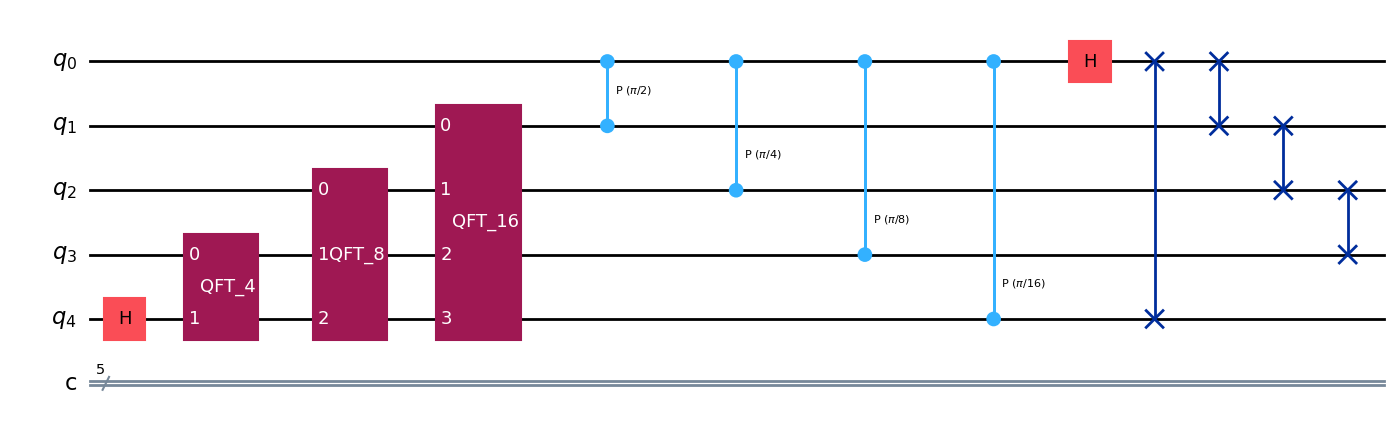

In [149]:
n = 5

circuit = QuantumCircuit(n, n)
CustomQFT(circuit, circuit.qubits, n, expand=True)

circuit.draw(output="mpl")

#### Compare with Library provided QFT

Library provided QFT has some minor optimizations. In particular, the number of swap gates required can be reduced significantly by effectively pushing them to the end of the circuit and adjusting the controlled-phase gates accordingly.)

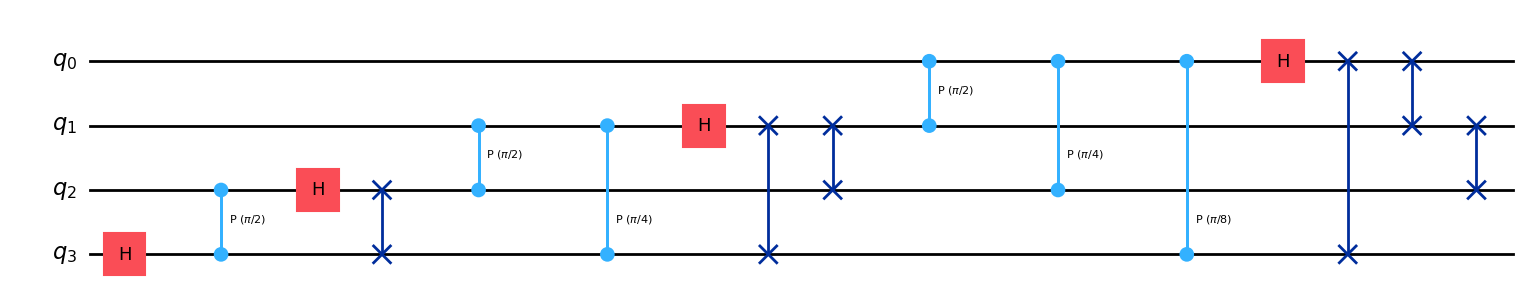

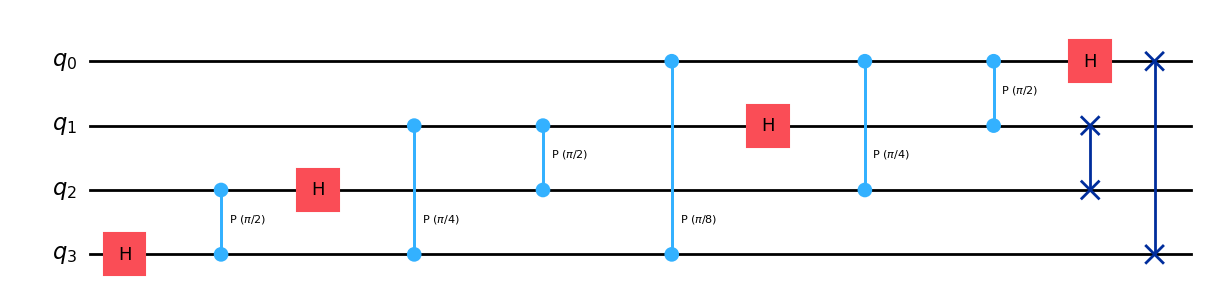

In [150]:
n = 4

custom = QuantumCircuit(n)
CustomQFT(custom, custom.qubits, n, expand=True)

transpiled = generate_preset_pass_manager(optimization_level=1, backend=AerSimulator()).run(custom)

display(transpiled.draw(output="mpl"))
display(QFT(n).decompose().draw(output="mpl"))


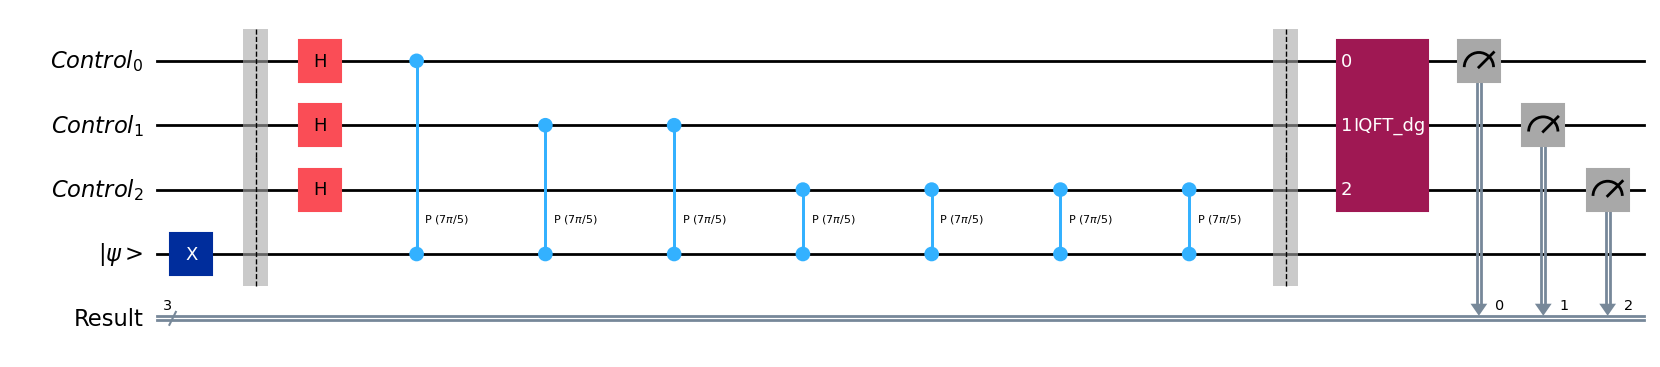

In [151]:
theta = 0.7
m = 3  # Number of control qubits

control_register = QuantumRegister(m, name="Control")
target_register = QuantumRegister(1, name="|ψ>")
output_register = ClassicalRegister(m, name="Result")
qc = QuantumCircuit(control_register, target_register, output_register)

# Prepare the eigenvector |ψ>
qc.x(target_register)
qc.barrier()

# Perform phase estimation
for index, qubit in enumerate(control_register):
    qc.h(qubit)
    for _ in range(2**index):
        qc.cp(2 * np.pi * theta, qubit, target_register)
qc.barrier()

# Do inverse quantum Fourier transform
qc.compose(
    QFT(m, inverse=True),
    inplace=True
)

# Measure everything
qc.measure(range(m), range(m))
display(qc.draw(output="mpl"))

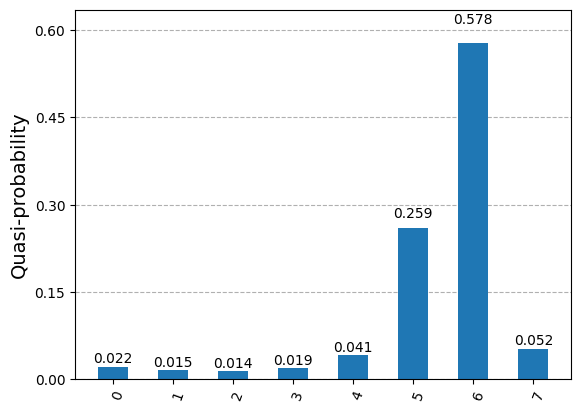

Most probable output: 6
Estimated theta: 0.75
Actual theta: 0.7


In [152]:
result = Sampler().run(qc).result()
display(plot_histogram(result.quasi_dists))

most_probable = max(result.quasi_dists[0], key=result.quasi_dists[0].get)

print(f"Most probable output: {most_probable}")
print(f"Estimated theta: {most_probable/2**m}")
print(f"Actual theta: {theta}")